In [1]:
import cv2
from tutils import tfilename
import numpy as np
from skimage.exposure import histogram
from sklearn.metrics import mutual_info_score
from PIL import Image
import torch
import torchvision
import torchvision.transforms.functional as F

# lm0: min 0.7, max 1.75
# im = cv2.imread("001.bmp", cv2.IMREAD_GRAYSCALE)
def test_mi(lm, im, br=1.5, ct=1.4):
    # lm = [165, 291]
    # lm = [100,308]
    # print()
    ps_half = 32
    patch = im[max(lm[0]-ps_half, 0):min(lm[0]+ps_half, 384), max(0, lm[1]-ps_half):min(lm[1]+ps_half, 384)]
    assert patch.shape[0] > 0 and patch.shape[1] > 0, f"Got patch.shape {patch.shape}"

    def get_fea(patch):
        fea = np.zeros((256,))
        hist, idx = histogram(patch, nbins=256)
        for hi, idi in zip(hist, idx):
            # print(hi, idi, i, j)
            fea[idi] = hi
        return fea
        
    # fea1 = get_fea(np.clip(patch-np.mean(patch).astype(int), -128, 127))
    fea1 = get_fea(patch)
    # cv2.imwrite("patch1.jpg", patch)

    # fn_aug = transforms.ColorJitter(brightness=0.9)
    patch_aug = Image.fromarray(patch)
    patch_aug = F.adjust_brightness(patch_aug, br)
    patch_aug = F.adjust_contrast(patch_aug, ct)
    # patch_aug = F.adjust_saturation(patch_aug, 5)
    # patch_aug = F.adjust_hue(patch_aug, -0.2)
    patch_aug = np.array(patch_aug)
    # print("??????")
    # cv2.imwrite("patch2.jpg", patch_aug)
    fea2 = get_fea(patch_aug)
    # fea2 = get_fea(np.clip(patch_aug-np.mean(patch_aug).astype(int), -128, 127))

    mi0 = mutual_info_score(fea1, fea1)
    mi = mutual_info_score(fea1, fea2)
    return mi0, mi
# print("lm ", lm, ",  entr ", entr[lm[0], lm[1]], "self_mi, aug_mi ", mi0, mi)

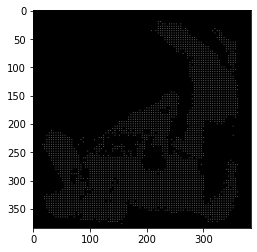

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
im_path = tfilename('/home1/quanquan/datasets/Cephalometric/', "RawImage/TrainingData", "002.bmp")
im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
entr = np.load('/home1/quanquan/datasets/Cephalometric/entr1/train/2.npy')
im = cv2.resize(im, (384, 384))

self_mi_list = np.zeros_like(im)
aug_mi_list = np.zeros_like(im)

for i in range(0, 384, 4):
    for j in range(0, 384, 4):
        print("processing ", i, j , end="\r")
        mi0, mi = test_mi((i, j), im)
        self_mi_list[i,j] = mi0
        aug_mi_list[i,j] = mi

plt.imshow(aug_mi_list, cmap='gray')

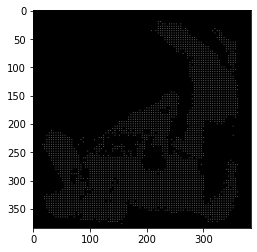

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
plt.style.use('ggplot')
plt.imshow(aug_mi_list, cmap='gray')

In [23]:
thres = [0, 1, 2, 3, 4, 5, 6, 999]
low = []
med = []
high = []
listlist = [[],[],[],[],[],[],[]]

for i in range(0, 384, 2):
    for j in range(0, 384, 2):
        idx = min(entr[i,j].astype(int), 6)
        # print("idx ", idx, end="\r")
        listlist[idx].append([entr[i,j], aug_mi_list[i,j], self_mi_list[i,j], aug_mi_list[i,j]/(self_mi_list[i,j]+1e-8), (self_mi_list[i,j] - aug_mi_list[i,j])/(self_mi_list[i,j]+1e-8)])

listlist = [np.array(alist) for alist in listlist]

In [24]:
# print(low.mean(axis=0))
# print(med.mean(axis=0))
# print(high.mean(axis=0))
from einops import reduce

# print(listlist.shape) # 7 3 n
print(listlist[0].shape)
reslist = []
for alist in listlist:
    res = alist.mean(axis=0)
    print(res)
    reslist.append(res)
reslist = np.array(reslist)

(671, 5)
[0.13032852 0.00745156 0.55588674 0.00248385 0.30004968]
[1.69072509 0.09351306 0.48525695 0.0379107  0.20050547]
[2.60640791 0.08855025 0.44934102 0.03571755 0.18133352]
[3.4780133  0.06489761 0.46279204 0.02464907 0.19996875]
[4.42354392 0.10269214 0.63742944 0.03636561 0.21016066]
[5.39695417 0.15088608 0.69341772 0.05295359 0.19464135]
[6.26714208 0.12138728 0.71531792 0.04142582 0.21001927]


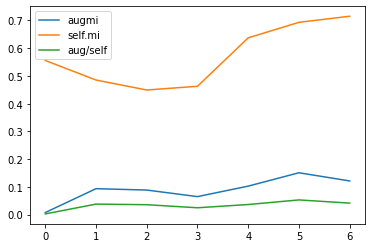

In [19]:
reslist.shape
# plt.plot(np.arange(0,8), reslist[:,0], label='entr')
plt.plot(np.arange(0,7), reslist[:,1], label='augmi')
plt.plot(np.arange(0,7), reslist[:,2], label='self.mi')
plt.plot(np.arange(0,7), reslist[:,3], label='aug/self')
plt.legend()
# plt.show()

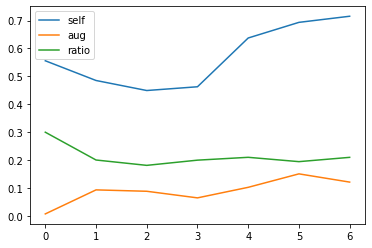

In [29]:
# plt.plot(np.arange(0,7), reslist[:,3], label='aug/self')
plt.plot(np.arange(0,7), reslist[:,2], label='self')
plt.plot(np.arange(0,7), reslist[:,1], label='aug')
plt.plot(np.arange(0,7), reslist[:,4], label='ratio') # (self-aug)/self
plt.legend()

In [4]:
im_path = tfilename('/home1/quanquan/datasets/Cephalometric/', "RawImage/TrainingData", "002.bmp")
im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
entr = np.load('/home1/quanquan/datasets/Cephalometric/entr1/train/2.npy')
im = cv2.resize(im, (384, 384))

self_mi_list = np.zeros_like(im)
aug_mi_list = np.zeros_like(im)

for i in range(0, 384, 2):
    for j in range(0, 384, 2):
        print("processing ", i, j , end="\r")
        mi0, mi = test_mi((i, j), im)
        self_mi_list[i,j] = mi0
        aug_mi_list[i,j] = mi

thres = [0, 1, 2, 3, 4, 5, 6, 7, 999]
low = []
med = []
high = []
listlist = [[],[],[],[],[],[],[]]

for i in range(0, 384, 2):
    for j in range(0, 384, 2):
        idx = entr[i,j].astype(int)
        idx = max(idx, 7)
        listlist[idx].append([entr[i,j], aug_mi_list[i,j], self_mi_list[i,j], aug_mi_list[i,j]/(self_mi_list[i,j]+1e-8)])

listlist = [np.array(alist) for alist in listlist]

KeyboardInterrupt: 

In [2]:
%matplotlib inline
from cProfile import label
# import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("ggplot")
lm = [165, 291]
# lm = [100,308]
lms = [[165, 291], [100,308], [20,20]]
im_path = tfilename('/home1/quanquan/datasets/Cephalometric/', "RawImage/TrainingData", "002.bmp")
im = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im, (384, 384))
entr = np.load('/home1/quanquan/datasets/Cephalometric/entr1/train/2.npy')

def get_augmi_list(lm, im):
    augmi_list = []
    print(lm, entr[lm[0], lm[1]])
    for s in range(10):
        s = s / 10
        selfmi, augmi = test_mi(lm=lm, im=im, br=1.+s, ct=1.+s)
        augmi_list.append(augmi)
    return augmi_list
        # print(entr[lm[0], lm[1]], s, selfmi, augmi)

# for lm in lms:
#     get_augmi_list(lm, im)

i = 0
xx_list = []
auglistlist = []
while True:
    lm = [np.random.randint(384)  ,np.random.randint(384)]
    print("[???] lm ", lm , "  entr ", entr[lm[0], lm[1]], end="   \r")
    if entr[lm[0], lm[1]] >= 4:
        augmi_list = get_augmi_list(lm, im)
        xx = np.arange(10)*0.1+1.0
        i = i + 1
        xx_list.append(xx)
        auglistlist.append(auglistlist)
        print("[***] Got i=", i)
    if i >5: break

xx_list = np.concatenate(xx_list)
print(xx_list.shape)
auglistlist = np.concatenate(auglistlist)
print(auglistlist.shape)
# sns.plot(xx_list, np.array(auglistlist))
plt.legend()

In [1]:
i = 0
while True:
    lm = [np.random.randint(384)  ,np.random.randint(384)]
    if entr[lm[0], lm[1]] < 2:
        get_augmi_list(lm, im)
        i = i + 1
        print("Got i=", i)
    if i >9: break

plt.legend()

NameError: name 'np' is not defined